In [1]:
import pandas as pd
import geopandas as gpd
import random
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
import random, os, sys
import numpy as np
import zipfile
import seaborn as sns
from eppy.modeleditor import IDF
from eppy.runner.run_functions import runIDFs
iddfile = "C:/EnergyPlusV9-4-0/Energy+.idd"
IDF.setiddname(iddfile)

pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
data_dir = 'C:/Users/mmh/Documents/Data/'
data_dir2 = "C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/9.Data/"
data_maps = 'C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/8.Maps/'

sys.path.insert(0, 'C:/Users/mmh/Documents/Codes/cross-sectro-transp-energy-model/')
# importlib.reload(sys.modules['src.calculation'])
from src.func_buildings import *

scenario = 'rural'
if scenario == 'downtown':
    selected_ID = gpd.read_file(data_dir+"Buildings/GA/Atlanta downtown_53.shp")
    building_schedule_all = pd.read_feather(data_dir+'Buildings/Schedule/100BG_default.feather')
    building_schedule_summer = pd.read_feather(data_dir+'Buildings/Schedule/100BG_summer.feather')
    building_schedule_winter = pd.read_feather(data_dir+'Buildings/Schedule/100BG_winter.feather')
    building_set = pd.read_feather(data_dir+'Buildings/Old Occ/schedule_100BG.feather')
elif scenario == 'rural':
    selected_ID = gpd.read_file(data_dir+"Buildings/GA/Fulton rural.shp")
    building_schedule_all = pd.read_feather(data_dir+'Buildings/Schedule/Rural_default.feather')
    building_schedule_summer = pd.read_feather(data_dir+'Buildings/Schedule/Rural_summer.feather')
    building_schedule_winter = pd.read_feather(data_dir+'Buildings/Schedule/Rural_winter.feather')
    building_set = pd.read_feather(data_dir+'Buildings/Old Occ/schedule_rural.feather')

selected_ID['GEOID_2'] = selected_ID['GEOID'].str[0:11]
print(len(set(building_schedule_all.ID)))
building_schedule_all.head()

2701


,ID,hour,GEOID,BuildingClass,capacity,PBuilding,PCluster,occupancy,stay_type,occupancy_building,occupancy_building_frac
0,5007013188323,0,131210103091,Residential,32.0,1.0,0.005696,1367.416405,b'home',29.433918,0.919810
1,5007013188323,1,131210103091,Residential,32.0,1.0,0.005696,1392.684109,b'home',29.977810,0.936807
2,5007013188323,2,131210103091,Residential,32.0,1.0,0.005696,1410.973045,b'home',30.371483,0.949109
3,5007013188323,3,131210103091,Residential,32.0,1.0,0.005696,1421.636921,b'home',30.601025,0.956282
4,5007013188323,4,131210103091,Residential,32.0,1.0,0.005696,1385.765090,b'home',29.828877,0.932152


In [2]:
all_ID = selected_ID.ID.values
print(len(set(all_ID)))
building_schedule_all = building_schedule_all[building_schedule_all.ID.isin(all_ID)]
building_schedule_summer = building_schedule_summer[building_schedule_summer.ID.isin(all_ID)]
building_schedule_winter = building_schedule_winter[building_schedule_winter.ID.isin(all_ID)]

3210


In [3]:
building_schedule_all.groupby('BuildingClass')['capacity'].median()

BuildingClass
Residential    26.819943
Industrial     68.092005
Commercial     69.252772
Name: capacity, dtype: float64

In [4]:
# test_df = pd.DataFrame()
# # Iterate over each unique ID
# for k in building_schedule_all['ID'].unique():
#     # Generate a random number between -0.1 and 0.1
#     rn = random.uniform(-0.1, 0.1)
#     # Extract data for the current ID
#     tmp = building_schedule_all[building_schedule_all['ID'] == k].copy()
#     # Update the value at hour 23
#     tmp.loc[tmp['hour'] == 23, 'occupancy_building_frac'] = rn + tmp.loc[tmp['hour'] == 0, 'occupancy_building_frac'].iloc[0]
#     # Calculate smoothed values for hours 22 to 11
#     for j in range(22, 10, -1):
#         tmp.loc[tmp['hour'] == j, 'occupancy_building_frac'] = rn + (tmp.loc[tmp['hour'] == j + 1, 'occupancy_building_frac'].iloc[0] + tmp.loc[tmp['hour'] == j, 'occupancy_building_frac'].iloc[0]) / 2
#     # Append the data to the result DataFrame
#     test_df = pd.concat([test_df, tmp], ignore_index=True)

# sns.lineplot(data=test_df,x='hour',y='occupancy_building_frac',hue='BuildingClass')

In [5]:
print(len(set(building_schedule_all.GEOID)))
print(len(set(building_schedule_all.ID)))
building_schedule_all.groupby('BuildingClass')['ID'].nunique()

17
2701


BuildingClass
Residential    1277
Industrial     1095
Commercial      329
Name: ID, dtype: int64

In [6]:
GA_shp = gpd.read_file(data_maps+'geo/tl_2020/tl_2020_13_tract.zip', index_col=False)
GA_shp.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,13,099,090500,13099090500,905,Census Tract 905,G5020,S,340970567,3670838,+31.1995791,-084.9937511,"POLYGON ((-85.11460 31.27733, -85.11449 31.277..."
1,13,099,090400,13099090400,904,Census Tract 904,G5020,S,202255980,924285,+31.3138364,-084.8929190,"POLYGON ((-84.99042 31.27632, -84.99037 31.277..."
2,13,099,090200,13099090200,902,Census Tract 902,G5020,S,297097657,2960992,+31.4453867,-084.9408107,"POLYGON ((-85.08718 31.37407, -85.08691 31.374..."
3,13,067,031209,13067031209,312.09,Census Tract 312.09,G5020,S,3407093,4863,+33.8558429,-084.4944273,"POLYGON ((-84.51004 33.85250, -84.50997 33.852..."
4,13,067,031207,13067031207,312.07,Census Tract 312.07,G5020,S,2775451,49508,+33.8710765,-084.4701703,"POLYGON ((-84.47968 33.86431, -84.47805 33.868..."


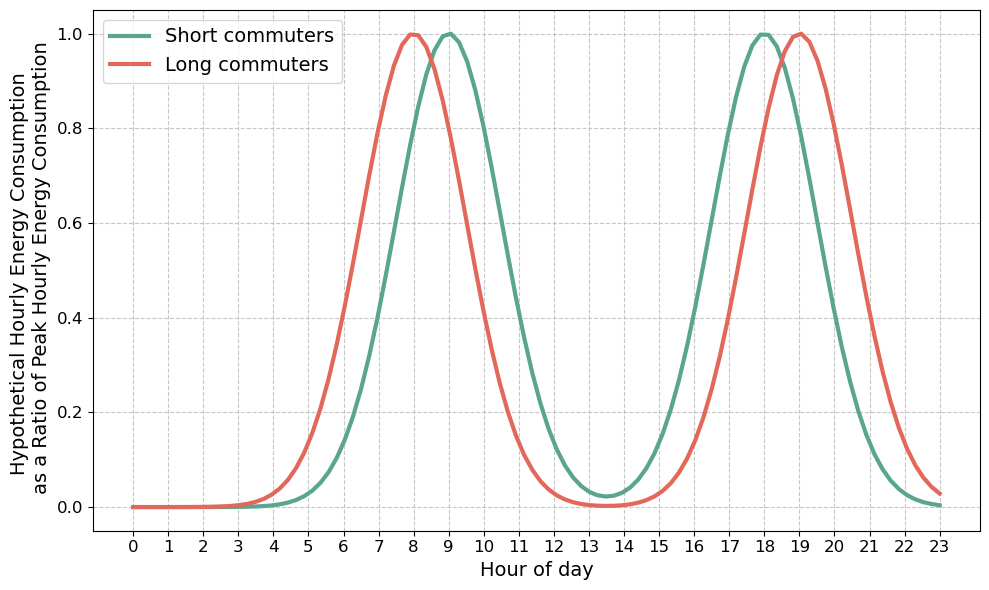

In [11]:
# Parameters for the distributions
mean_short_morning = 9  # Morning peak for short commuters
std_short_morning = 1.5  # Standard deviation for the morning peak

mean_short_evening = 18  # Evening peak for short commuters
std_short_evening = 1.5  # Standard deviation for the evening peak

mean_long_morning = 8  # Morning peak for long commuters
std_long_morning = 1.5  # Standard deviation for the morning peak

mean_long_evening = 19  # Evening peak for long commuters
std_long_evening = 1.5  # Standard deviation for the evening peak

# Generate hourly data
hours = np.linspace(0, 23, 100)

# Generate the distributions
short_commuters = (
    np.exp(-0.5 * ((hours - mean_short_morning) / std_short_morning) ** 2) +
    np.exp(-0.5 * ((hours - mean_short_evening) / std_short_evening) ** 2)
)

long_commuters = (
    np.exp(-0.5 * ((hours - mean_long_morning) / std_long_morning) ** 2) +
    np.exp(-0.5 * ((hours - mean_long_evening) / std_long_evening) ** 2)
)

# Normalize to a percentage scale
short_commuters = short_commuters / np.max(short_commuters)
long_commuters = long_commuters / np.max(long_commuters)

# Plotting the distributions
plt.figure(figsize=(10, 6))
plt.plot(hours, short_commuters, label='Short commuters', color=sns.color_palette("crest")[1], linewidth=3)
plt.plot(hours, long_commuters, label='Long commuters', color=sns.color_palette("flare")[1], linewidth=3)

# Customize the plot
plt.xlabel('Hour of day', fontsize=14)
plt.ylabel('Hypothetical Hourly Energy Consumption \n as a Ratio of Peak Hourly Energy Consumption', fontsize=14)
plt.xticks(np.arange(0, 24, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

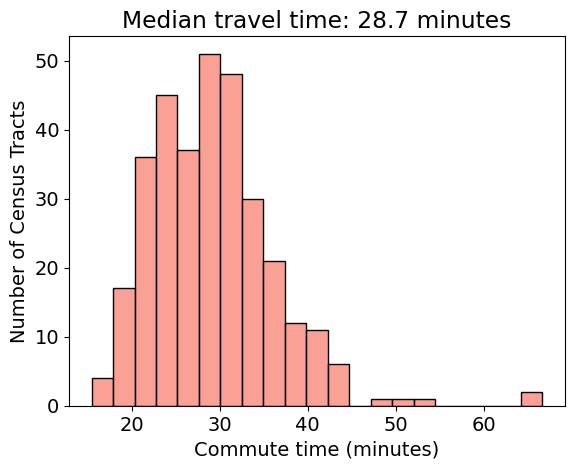

In [176]:
df = pd.read_csv(data_dir2+"ACS/commute time_Fulton_tract_2020/ACSST5Y2020.S0801-Data.csv")
df = df.iloc[1:,]
df['GEOID'] = df['GEO_ID'].str[9:]
df['S0801_C01_046E'] = pd.to_numeric(df['S0801_C01_046E'],errors='coerce')
df = df.rename(columns = {'S0801_C01_046E':'EST'})
df = df[['GEOID','EST']]

fig, ax = plt.subplots()

# Plot the count
sns.histplot(df['EST'], color='salmon', ax=ax, legend=False)

# Set the label for the y-axis for the count plot
ax.set_xlabel('Commute time (minutes)')
ax.set_ylabel('Number of Census Tracts')
med_commute = df['EST'].median()
ax.set_title(f"Median travel time: {med_commute:.1f} minutes")
# ax2.set_ylim(0,15)

# Display the plot
plt.show()

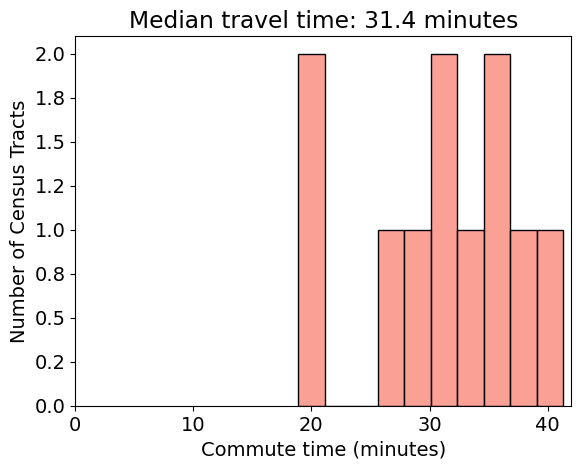

In [186]:
import matplotlib.ticker as ticker

tmp = selected_ID[['GEOID_2']].drop_duplicates()
tmp = pd.merge(tmp,GA_shp[['GEOID','geometry']],how='left',left_on='GEOID_2',right_on='GEOID')
tmp = pd.merge(tmp,df,on='GEOID',how='left')
# print(len(tmp))
tmp = gpd.GeoDataFrame(tmp[['GEOID', 'EST']], geometry=tmp['geometry'])

# Function to find the nearest Residence with a non-missing 'EST' value
def find_nearest_est(row, points):
    # Exclude the current row's Residence and rows with missing 'EST'
    possible_residences = points.loc[(points['GEOID'] != row['GEOID']) & ~points['EST'].isnull()]
    # Find the nearest Residence
    nearest_residence = possible_residences.iloc[points.geometry.distance(row.geometry).idxmin()]
    # Return the 'EST' value of the nearest Residence
    return nearest_residence['EST']

# Apply the function to impute missing 'EST' values
tmp['EST'] = tmp.apply(lambda row: row['EST'] if not pd.isnull(row['EST']) else find_nearest_est(row, tmp), axis=1)
tmp.head()

fig, ax = plt.subplots()

# Plot the count
sns.histplot(tmp['EST'], color='salmon', ax=ax, legend=False,bins=10)
plt.xlim(0,42)

# Set the label for the y-axis for the count plot
ax.set_xlabel('Commute time (minutes)')
ax.set_ylabel('Number of Census Tracts')
med_commute = tmp['EST'].median()
ax.set_title(f"Median travel time: {med_commute:.1f} minutes")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
# ax2.set_ylim(0,15)

# Display the plot
plt.show()

# New occupancy

In [166]:
for season in ['default','summer','winter']:
    if season == 'default':
        schedule = building_schedule_all[['hour','ID','occupancy_building_frac','BuildingClass']]
    elif season == 'summer':
        schedule = building_schedule_summer[['hour','ID','occupancy_building_frac','BuildingClass']]
    elif season == 'winter':
        schedule = building_schedule_winter[['hour','ID','occupancy_building_frac','BuildingClass']]
    
    # need to normalize for now otherwise the occupancy seems to be lower
    schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
    schedule = schedule.rename(columns={'occupancy_building_frac':'Occ'})
    schedule['hour'] = schedule['hour'] + 1

    print(len(set(schedule.ID)))  
    if season == 'default':
        schedule_occ = schedule.copy()
    elif season == 'summer':
        schedule_occ_summer = schedule.copy()
    elif season == 'winter':
        schedule_occ_winter = schedule.copy()

    # to idf format
    schedule['Occ'] = np.round(schedule['Occ'],2)
    schedule['Time'] = schedule['hour'].astype(str).str.zfill(2)+':00' # "Until: "+
    print(len(schedule))
    schedule = pd.melt(schedule, id_vars=['ID','BuildingClass','hour'], value_vars=['Time','Occ'])
    print(len(schedule))
    schedule.loc[schedule.variable=='Time','variable'] = 'Time '+schedule.loc[schedule.variable=='Time','hour'].astype(str)+" {hh:mm}"
    schedule.loc[schedule.variable=='Occ','variable'] = 'Value Until Time '+schedule.loc[schedule.variable=='Occ','hour'].astype(str)
    schedule = schedule.sort_values(['ID','hour'])
    schedule = schedule.groupby('ID').filter(lambda group: group['value'].notna().all())
    
    if season == 'default':
        occ_formatted = schedule.copy()
    elif season == 'summer':
        occ_formatted_summer = schedule.copy()
    elif season == 'winter':
        occ_formatted_winter = schedule.copy()
schedule_occ_summer.head()

2701
64824
129648
2701
64824
129648
2701
64824
129648


,hour,ID,Occ,BuildingClass
0,1,5007013188323,0.954876,Residential
1,2,5007013188323,0.970494,Residential
2,3,5007013188323,0.988030,Residential
3,4,5007013188323,1.000000,Residential
4,5,5007013188323,0.959796,Residential


(6.0, 21.0)

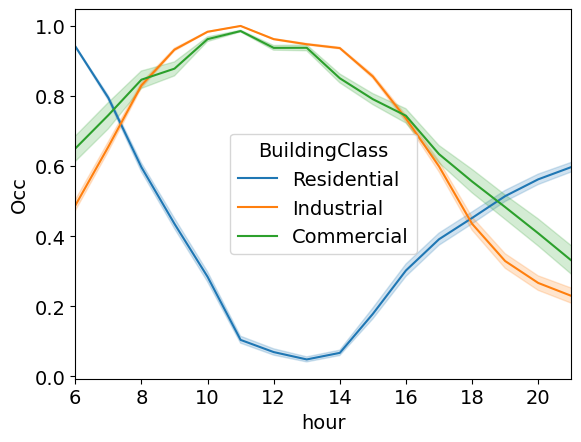

In [167]:
sns.lineplot(data=schedule_occ,x='hour',y='Occ',hue='BuildingClass')
plt.xlim(6,21)

# Old occupancy

In [168]:
building_set['ID'] = building_set['ID'].str.split("/", expand=True)[0].astype('int64')
building_set = building_set[building_set.ID.isin(all_ID)]
print(len(set(building_set.ID)))
print('size: '+str(round(building_set.memory_usage(index=True).sum()/1e9,4))+'GB')
building_set.head()

3210
size: 0.1GB


,type,value,name,name2,ID
0,Schedule:Day:Interval,Medium Office HtgSetp SmrDsn|Sun Day,Name,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
1,Schedule:Day:Interval,Temperature,Schedule Type Limits Name,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
2,Schedule:Day:Interval,No,Interpolate to Timestep,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
3,Schedule:Day:Interval,24:00,Time 1 {hh:mm},Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
4,Schedule:Day:Interval,15.6,Value Until Time 1,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282


In [169]:
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                     (building_set.name2.str.lower().str.contains('occ')) & 
                     (building_set.name2.str.lower().str.contains('default', na=False))&
                     (~building_set.name2.str.lower().str.contains('space'))&
                     ~building_set.name2.str.lower().str.contains('wkdy day')]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
n = len(np.unique(df.ID))
print(n)
j = 0
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = pd.concat([schedule,x])
schedule.head()

3210


cat,Time,Value,ID
0,06:00,0,5007013188282
1,07:00,0.1,5007013188282
2,08:00,0.2,5007013188282
3,12:00,0.95,5007013188282
4,13:00,0.5,5007013188282


In [170]:
schedule_occ_old = schedule.copy()
schedule_occ_old['Time'] = pd.to_numeric(schedule_occ_old['Time'].str.split(":").str.get(0))
schedule_occ_old['Value'] = pd.to_numeric(schedule_occ_old['Value'])
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule_occ_old = pd.merge(hours,schedule_occ_old,how='left',on=['ID','Time'])
schedule_occ_old.drop_duplicates(inplace=True)
schedule_occ_old['Value'] = schedule_occ_old['Value'].fillna(method='bfill')
# schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule_occ_old['Value'] = pd.to_numeric(schedule_occ_old['Value'])
schedule_occ_old = pd.merge(schedule_occ_old,schedule_occ[['ID','BuildingClass']],how='left',on='ID')
schedule_occ_old.head()

,Time,ID,Value,BuildingClass
0,1,5007013188282,0.0,NaN
1,2,5007013188282,0.0,NaN
2,3,5007013188282,0.0,NaN
3,4,5007013188282,0.0,NaN
4,5,5007013188282,0.0,NaN


<Axes: xlabel='Time', ylabel='Value'>

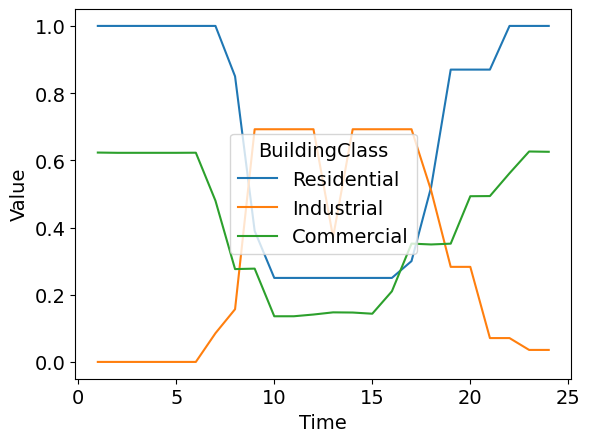

In [171]:
df_plot = schedule_occ_old.dropna()
df_plot = df_plot.groupby(['BuildingClass','Time']).agg({'Value':'mean'}).reset_index()
sns.lineplot(data = df_plot,x='Time',y='Value',hue='BuildingClass')

In [172]:
len(set(schedule_occ_old.ID))

3210

In [173]:
# summer
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                     (building_set.name2.str.lower().str.contains('occ')) & 
                     (building_set.name2.str.lower().str.contains('summer', na=False))&
                     (~building_set.name2.str.lower().str.contains('space'))&
                     ~building_set.name2.str.lower().str.contains('wkdy day')]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
n = len(np.unique(df.ID))
print(n)
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = pd.concat([schedule,x])
tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
print('Buildings with duplicated entries: '+str(len(tmp.ID)))
schedule_occ_old_summer = schedule.copy()
schedule_occ_old_summer['Time'] = pd.to_numeric(schedule_occ_old_summer['Time'].str.split(":").str.get(0))
schedule_occ_old_summer['Value'] = pd.to_numeric(schedule_occ_old_summer['Value'])
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule_occ_old_summer = pd.merge(hours,schedule_occ_old_summer,how='left',on=['ID','Time'])
schedule_occ_old_summer.drop_duplicates(inplace=True)
schedule_occ_old_summer['Value'] = schedule_occ_old_summer['Value'].fillna(method='bfill')
# schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule_occ_old_summer['Value'] = pd.to_numeric(schedule_occ_old_summer['Value'])
schedule_occ_old_summer = pd.merge(schedule_occ_old_summer,schedule_occ[['ID','BuildingClass']],how='left',on='ID')
schedule_occ_old_summer.head()

3210
Buildings with duplicated entries: 6


,Time,ID,Value,BuildingClass
0,1,5007013188282,0.0,NaN
1,2,5007013188282,0.0,NaN
2,3,5007013188282,0.0,NaN
3,4,5007013188282,0.0,NaN
4,5,5007013188282,0.0,NaN


In [174]:
# winter
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                     (building_set.name2.str.lower().str.contains('occ')) & 
                     (building_set.name2.str.lower().str.contains('winter'))&
                     ~building_set.name2.str.lower().str.contains('space') &
                     ~building_set.name2.str.lower().str.contains('wkdy day')]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
n = len(np.unique(df.ID))
print(n)
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = pd.concat([schedule,x])
tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
print('Buildings with duplicated entries: '+str(len(tmp.ID)))
schedule_occ_old_winter = schedule.copy()
schedule_occ_old_winter['Time'] = pd.to_numeric(schedule_occ_old_winter['Time'].str.split(":").str.get(0))
schedule_occ_old_winter['Value'] = pd.to_numeric(schedule_occ_old_winter['Value'])
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule_occ_old_winter = pd.merge(hours,schedule_occ_old_winter,how='left',on=['ID','Time'])
schedule_occ_old_winter.drop_duplicates(inplace=True)
schedule_occ_old_winter['Value'] = schedule_occ_old_winter['Value'].fillna(method='bfill')
# schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule_occ_old_winter['Value'] = pd.to_numeric(schedule_occ_old_winter['Value'])
schedule_occ_old_winter = pd.merge(schedule_occ_old_winter,schedule_occ[['ID','BuildingClass']],how='left',on='ID')
schedule_occ_old_winter.head()

KeyboardInterrupt: 

# Update Load

In [ ]:
def update_load(and_schedule_list,or_schedule_list,no_list,schedule_occ,schedule_occ_old):
    if len(no_list)==0:
        filter_condition = (building_set.type == 'Schedule:Day:Interval') & \
                    (building_set.name2.str.lower().str.contains('|'.join(or_schedule_list))) & \
                    (building_set.name2.str.lower().str.contains('|'.join(and_schedule_list)))
    else:
        filter_condition = (building_set.type == 'Schedule:Day:Interval') & \
                    (building_set.name2.str.lower().str.contains('|'.join(or_schedule_list))) & \
                    (building_set.name2.str.lower().str.contains('|'.join(and_schedule_list)) &
                        ~building_set.name2.str.lower().str.contains('|'.join(no_list)))
    df = building_set.loc[filter_condition]
    df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
    df['cat'] = df.name.str.split().str.get(0)
    n = len(np.unique(df.ID))
    print('Number of buildings: '+str(n))

    schedule = pd.DataFrame()
    for i in np.unique(df.ID):
        group = df[df.ID == i]
        x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
        x = x.rename_axis(None, axis=1).reset_index(drop=True)
        x['ID'] = i
        schedule = pd.concat([schedule,x])
    tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
    print('Buildings with duplicated entries: '+str(len(tmp.ID)))
    schedule['Time'] = pd.to_numeric(schedule['Time'].str.split(":").str.get(0))
    schedule['Value'] = pd.to_numeric(schedule['Value'])
    hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
    hours['ID'] = np.repeat(np.unique(df.ID),24)
    schedule = pd.merge(hours,schedule,how='left',on=['ID','Time']) # somehow there are duplciates
    schedule.drop_duplicates(inplace=True)
    schedule['hour'] = schedule['Time']
    schedule['Value'] = schedule['Value'].fillna(method='bfill')
    # schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
    schedule['Value'] = pd.to_numeric(schedule['Value']) 

    # get variables
    schedule = pd.merge(schedule,schedule_occ.rename(columns={'hour':'Time'}),on=['Time','ID'])
    schedule = pd.merge(schedule,schedule_occ_old.rename(columns={'Value':'OccOld'}),on=['Time','ID'])
    schedule.drop_duplicates(inplace=True)
    print('Number of buildings double check: '+str(len(set(schedule.ID))))
    min_val = schedule.groupby('ID')['Value']
    schedule['min'] = min_val.transform('min')

    # update schedule
    schedule['ValueNew'] = schedule['Value']
    schedule.loc[schedule['OccOld']==0,'OccOld'] = 0.01 # make sure denominator is not zero
    schedule['ValueNew'] = schedule['min'] + (schedule['Value']-schedule['min'])*schedule['Occ']/schedule['OccOld']
    schedule.loc[schedule['ValueNew']>1,'ValueNew'] = 1 # make sure it does not exceed max frac
    schedule = schedule.drop_duplicates() # remvoe duplicates
    schedule_table = schedule.copy()
    
    # to idf format
    schedule['ValueNew'] = np.round(schedule['ValueNew'],2)
    schedule['Time'] = schedule['hour'].astype(str).str.zfill(2)+':00' # "Until: "+
    schedule = pd.melt(schedule, id_vars=['ID','hour'], value_vars=['Time','ValueNew'])
    schedule.loc[schedule.variable=='Time','variable'] = 'Time '+schedule.loc[schedule.variable=='Time','hour'].astype(str)+" {hh:mm}"
    schedule.loc[schedule.variable=='ValueNew','variable'] = 'Value Until Time '+schedule.loc[schedule.variable=='ValueNew','hour'].astype(str)
    schedule = schedule.sort_values(['ID','hour'])
    schedule.drop_duplicates(inplace=True)
    schedule = schedule.groupby('ID').filter(lambda group: group['value'].notna().all())
    schedule_formatted = schedule.copy()
    
    return(schedule_table,schedule_formatted)

# Update equipment

In [ ]:
and_eqp_list = ['default']
or_eqp_list = ['equip','eqp']
no_list = ['wkdy day','wntrdsn','gas','sun day']
schedule_eqp,eqp_formatted = update_load(and_eqp_list,or_eqp_list,no_list,schedule_occ,schedule_occ_old)
eqp_formatted.head()

In [ ]:
and_eqp_list = ['summer']
or_eqp_list = ['equip','eqp']
no_list = ['wkdy day','wntrdsn','gas','sun day']
schedule_eqp_summer,eqp_formatted_summer = update_load(and_eqp_list,or_eqp_list,no_list,schedule_occ_summer,schedule_occ_old_summer)
eqp_formatted_summer.head()

In [ ]:
and_eqp_list = ['winter']
or_eqp_list = ['equip','eqp']
no_list = ['wkdy day','wntrdsn','gas','sun day']
schedule_eqp_winter,eqp_formatted_winter = update_load(and_eqp_list,or_eqp_list,no_list,schedule_occ_winter,schedule_occ_old_winter)
eqp_formatted_winter.head()

# Update Lights

In [ ]:
and_light_list = ['default']
or_light_list = ['light']
no_list = ['wkdy day','wntrdsn','fan','sun day','exterior']
schedule_light,light_formatted = update_load(and_light_list,or_light_list,no_list,schedule_occ,schedule_occ_old)
light_formatted.head()

In [ ]:
and_light_list = ['summer']
or_light_list = ['light']
no_list = ['wkdy day','wntrdsn','fan','sun day','exterior']
schedule_light_summer,light_formatted_summer = update_load(and_light_list,or_light_list,no_list,schedule_occ_summer,schedule_occ_old_summer)
light_formatted_summer.head()

In [ ]:
and_light_list = ['winter']
or_light_list = ['light']
no_list = ['wkdy day','wntrdsn','fan','sun day','exterior']
schedule_light_winter,light_formatted_winter = update_load(and_light_list,or_light_list,no_list,schedule_occ_winter,schedule_occ_old_winter)
light_formatted_winter.head()

# Demographcis / Commute Time

## commute time ACS

In [84]:
long_commute = tmp.loc[(tmp.EST>med_commute),'GEOID'].values
short_commute = tmp.loc[(tmp.EST<=med_commute),'GEOID'].values
print(len(long_commute))
print(len(short_commute))

8
3


# Compare plot

## schedule

In [87]:
plt.rcParams.update({'font.size': 14})

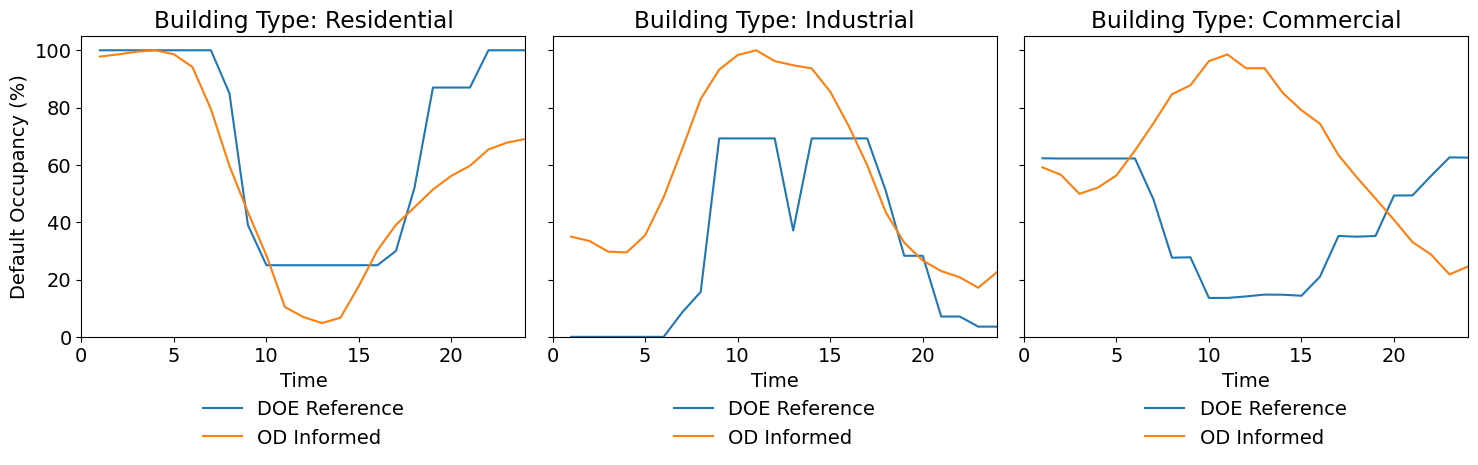

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Loop through each BuildingClass
for i, building_class in enumerate(['Residential','Industrial','Commercial']):
    # Filter data for the current BuildingClass
    data_old = schedule_occ_old[schedule_occ_old['BuildingClass'] == building_class].copy()
    data_old['Value'] = data_old['Value']*100
    data_old = data_old.rename(columns = {'BuildingClass':'Building Type'})
    data_new = schedule_occ[schedule_occ['BuildingClass'] == building_class].copy()
    data_new['Occ'] = data_new['Occ']*100
    data_new = data_new.rename(columns = {'BuildingClass':'Building Type'})

    # Plot DOE Reference
    sns.lineplot(data=data_old, y='Value', x='Time', label='DOE Reference', ax=axes[i],errorbar=None)

    # Plot OD Informed
    sns.lineplot(data=data_new, y='Occ', x='hour', label='OD Informed', ax=axes[i],errorbar=None)

    # Set labels and limits
    axes[i].set_ylabel('Default Occupancy (%)')
    axes[i].set_ylim(0, 105)
    axes[i].set_xlim(0, 24)
    axes[i].set_title(f'Building Type: {building_class}')
    
    axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

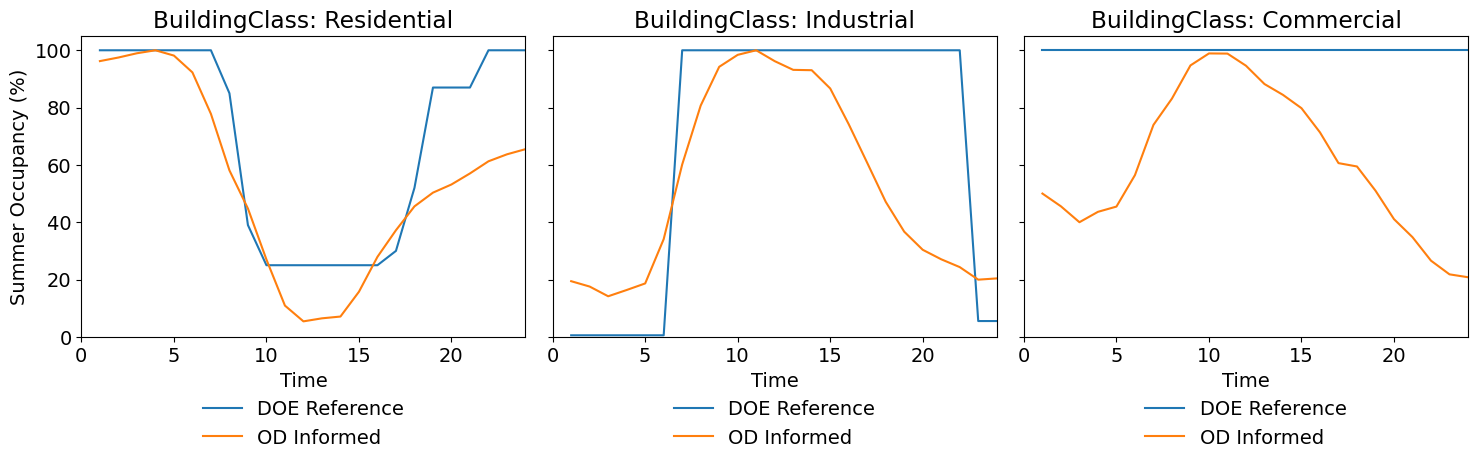

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Loop through each BuildingClass
for i, building_class in enumerate(['Residential','Industrial','Commercial']):
    # Filter data for the current BuildingClass
    data_old = schedule_occ_old_summer[schedule_occ_old_summer['BuildingClass'] == building_class].copy()
    data_old['Value'] = data_old['Value']*100
    data_new = schedule_occ_summer[schedule_occ_summer['BuildingClass'] == building_class].copy()
    data_new['Occ'] = data_new['Occ']*100

    # Plot DOE Reference
    sns.lineplot(data=data_old, y='Value', x='Time', label='DOE Reference', ax=axes[i],errorbar=None)

    # Plot OD Informed
    sns.lineplot(data=data_new, y='Occ', x='hour', label='OD Informed', ax=axes[i],errorbar=None)

    # Set labels and limits
    axes[i].set_ylabel('Summer Occupancy (%)')
    axes[i].set_ylim(0, 105)
    axes[i].set_xlim(0, 24)
    axes[i].set_title(f'BuildingClass: {building_class}')
    
    axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

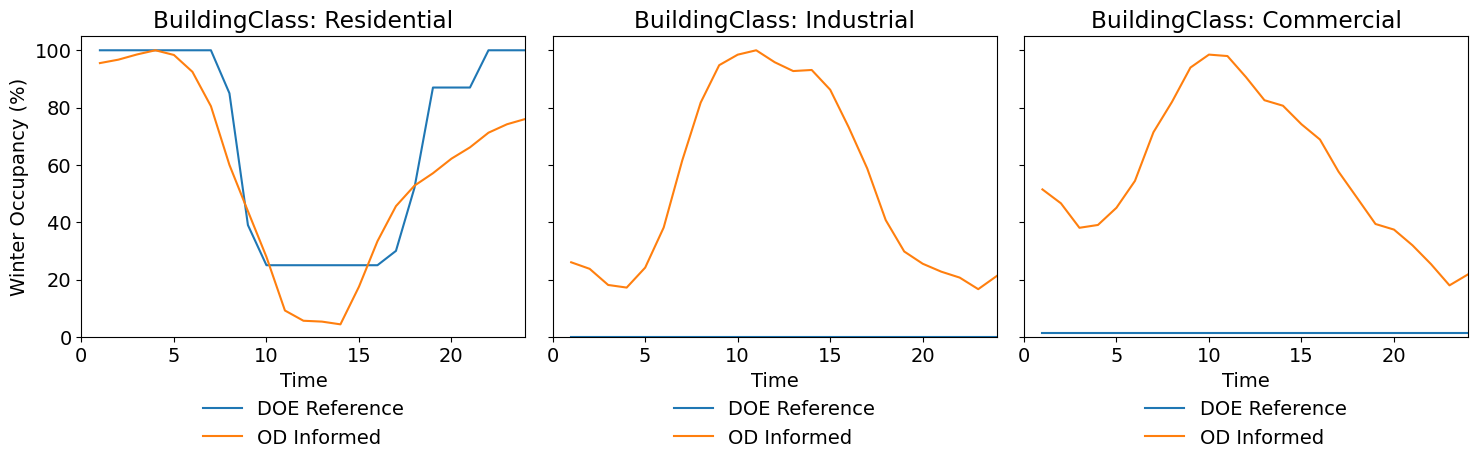

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Loop through each BuildingClass
for i, building_class in enumerate(['Residential','Industrial','Commercial']):
    # Filter data for the current BuildingClass
    data_old = schedule_occ_old_winter[schedule_occ_old_winter['BuildingClass'] == building_class].copy()
    data_old['Value'] = data_old['Value']*100
    data_new = schedule_occ_winter[schedule_occ_winter['BuildingClass'] == building_class].copy()
    data_new['Occ'] = data_new['Occ']*100

    # Plot DOE Reference
    sns.lineplot(data=data_old, y='Value', x='Time', label='DOE Reference', ax=axes[i],errorbar=None)

    # Plot OD Informed
    sns.lineplot(data=data_new, y='Occ', x='hour', label='OD Informed', ax=axes[i],errorbar=None)

    # Set labels and limits
    axes[i].set_ylabel('Winter Occupancy (%)')
    axes[i].set_ylim(0, 105)
    axes[i].set_xlim(0, 24)
    axes[i].set_title(f'BuildingClass: {building_class}')
    
    axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [91]:
tmp = schedule_occ_winter.groupby(['BuildingClass','hour']).agg({'Occ':'std'}).reset_index()
tmp.groupby('BuildingClass').agg({'Occ':'mean'})
# schedule_occ_winter.loc[schedule_occ_winter['BuildingClass'] == 'Residential','Occ'].describe()

,Occ
BuildingClass,
Residential,0.158619
Industrial,0.200949
Commercial,0.242476


In [92]:
tmp = schedule_occ_old_winter.groupby(['BuildingClass','Time']).agg({'Value':'std'}).reset_index()
tmp.groupby('BuildingClass').agg({'Value':'mean'})
# schedule_occ_old_winter.loc[schedule_occ_old_winter['BuildingClass'] == 'Residential','Value'].describe()

,Value
BuildingClass,
Residential,0.000000
Industrial,0.000000
Commercial,0.109598


## equipment

Text(0, 0.5, 'Default electric equipment schedule (fractional)')

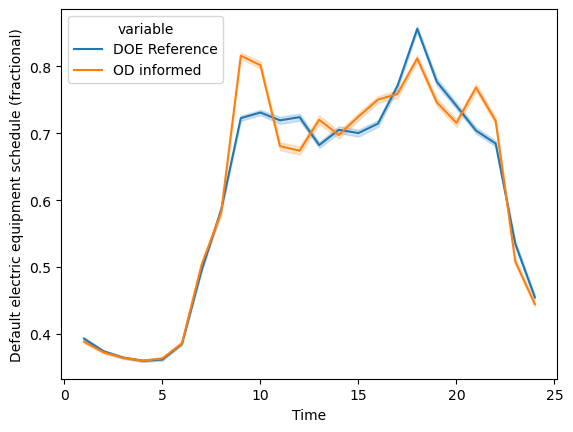

In [36]:
df = pd.melt(schedule_eqp,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Default electric equipment schedule (fractional)')

Text(0, 0.5, 'Summer electric equipment schedule (fractional)')

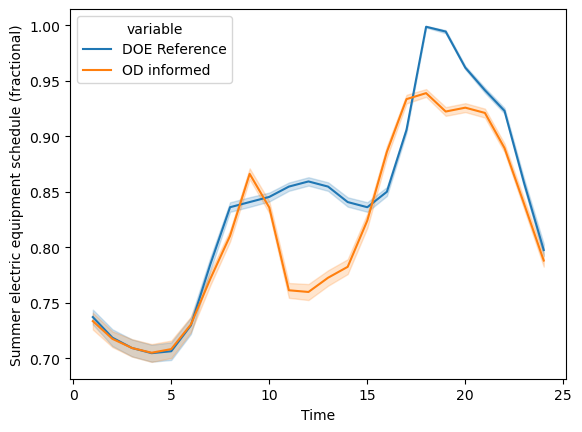

In [37]:
df = pd.melt(schedule_eqp_summer,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Summer electric equipment schedule (fractional)')

Text(0, 0.5, 'Winter electric equipment schedule (fractional)')

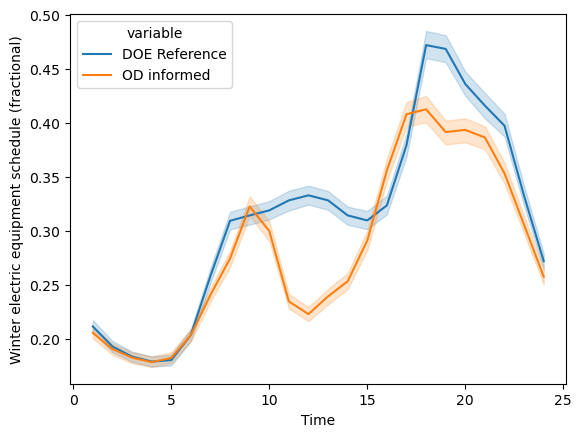

In [38]:
df = pd.melt(schedule_eqp_winter,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Winter electric equipment schedule (fractional)')

## Lights

Text(0, 0.5, 'Default lights schedule (fractional)')

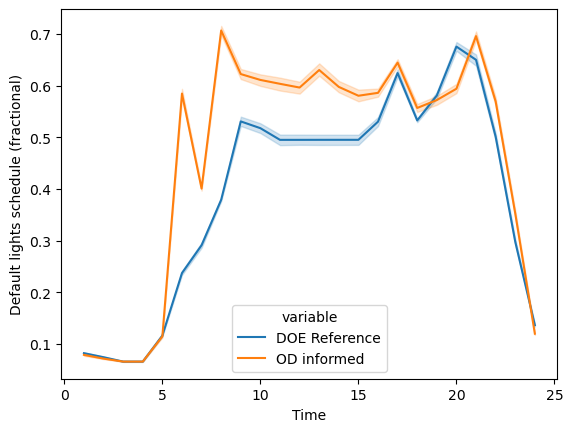

In [39]:
df = pd.melt(schedule_light,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Default lights schedule (fractional)')

Text(0, 0.5, 'Summer light schedule (fractional)')

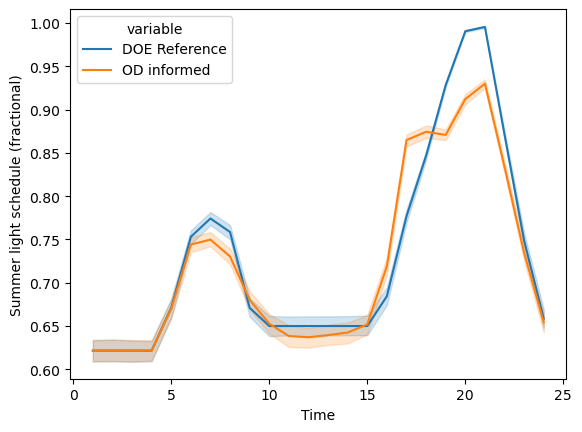

In [40]:
df = pd.melt(schedule_light_summer,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Summer light schedule (fractional)')

Text(0, 0.5, 'Winter light schedule (fractional)')

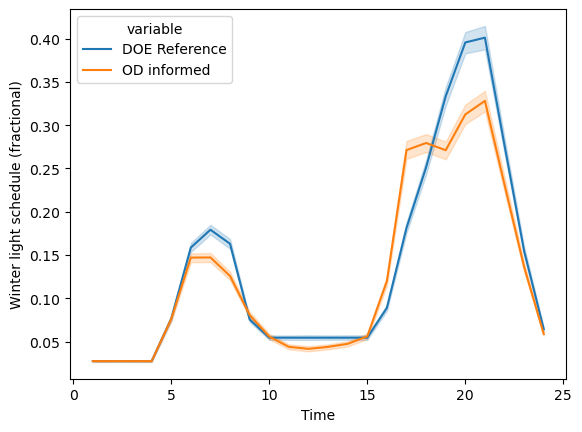

In [41]:
df = pd.melt(schedule_light_winter,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Winter light schedule (fractional)')

# Demographic plot

In [42]:
data_new = schedule_occ.copy()
data_new = pd.merge(data_new,selected_ID[['ID','GEOID_2']],how='left',on='ID')
data_new = data_new[data_new.BuildingClass=='Residential']
print(len(set(data_new.ID)))
data_new['category'] = np.nan
data_new.loc[data_new.GEOID_2.isin(long_commute),'category'] = 'long commute'
data_new.loc[data_new.GEOID_2.isin(short_commute),'category'] = 'short commute'
# data_new.loc[data_new.GEOID_2.isin(high_inc),'category'] = 'high income'
# data_new.loc[data_new.GEOID_2.isin(low_inc),'category'] = 'low income'
data_new['Occ'] = data_new['Occ']*100
data_new['category'] = pd.Categorical(data_new['category'], ordered=True, categories=['long commute', 'short commute'])
data_new.head()

2785


,hour,ID,Occ,BuildingClass,GEOID_2,category
0,1,5009016211610,70.938493,Residential,13121012000,long commute
1,2,5009016211610,79.257614,Residential,13121012000,long commute
2,3,5009016211610,96.592858,Residential,13121012000,long commute
3,4,5009016211610,100.000000,Residential,13121012000,long commute
4,5,5009016211610,99.781154,Residential,13121012000,long commute


In [43]:
def normalize_0_100(x):
    return (x - x.min())* 100 / (x.max() - x.min())
data_new['Occ_normalized'] = data_new.groupby(['category'])['Occ'].transform(normalize_0_100)

C:\Users\mmh\AppData\Local\Temp\ipykernel_11592\3640474392.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_new, y='Occ', x='hour',hue='category', palette=custom_palette,ci=None)


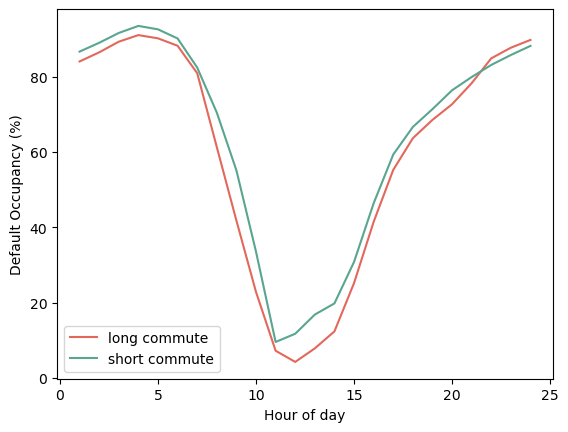

In [44]:
custom_palette = {"long commute":sns.color_palette("flare")[1],
                   "short commute":sns.color_palette("crest")[1]}
sns.lineplot(data=data_new, y='Occ', x='hour',hue='category', palette=custom_palette,ci=None)
plt.ylabel('Default Occupancy (%)')
plt.xlabel('Hour of day')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
plt.show()

In [45]:
data_new = schedule_occ_old.copy()
print(len(set(data_new.ID)))
data_new = pd.merge(data_new,selected_ID[['ID','GEOID_2']],how='left',on='ID')
data_new = data_new[data_new.BuildingClass=='Residential']
data_new['category'] = np.nan
data_new.loc[data_new.GEOID_2.isin(long_commute),'category'] = 'long commute'
data_new.loc[data_new.GEOID_2.isin(short_commute),'category'] = 'short commute'
data_new['Value'] = data_new['Value']*100
data_new['category'] = pd.Categorical(data_new['category'], ordered=True, categories=['long commute', 'short commute'])

data_new.head()

5996


,Time,ID,Value,BuildingClass,GEOID_2,category
1152,1,5009016211610,100.0,Residential,13121012000,long commute
1153,1,5009016211610,100.0,Residential,13121012000,long commute
1154,1,5009016211610,100.0,Residential,13121012000,long commute
1155,1,5009016211610,100.0,Residential,13121012000,long commute
1156,1,5009016211610,100.0,Residential,13121012000,long commute


C:\Users\mmh\AppData\Local\Temp\ipykernel_11592\1299507444.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_new, y='Value', x='Time',hue='category', palette=custom_palette,ci=None)


Text(0.5, 0, 'Hour of day')

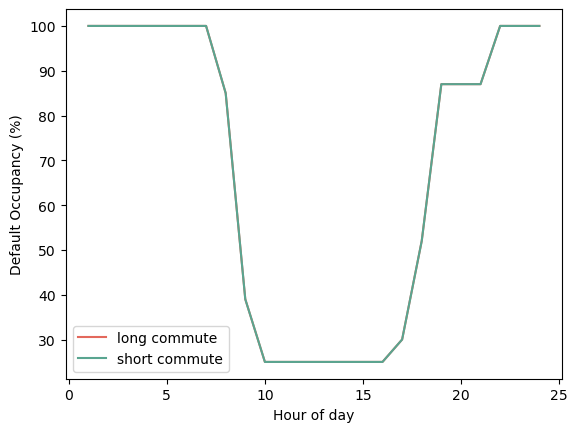

In [46]:
sns.lineplot(data=data_new, y='Value', x='Time',hue='category', palette=custom_palette,ci=None)
plt.ylabel('Default Occupancy (%)')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left')
plt.xlabel('Hour of day')